## Real-Time Micro Mobility(Bike) Analysis and Availability - Dashboard

**Project by:** [Rohith Raj Thalla](https://github.com/rohithrajthalla)  
**Dataset Source:** [Oslo Bysykkel GBFS API](https://gbfs.urbansharing.com/oslobysykkel.no/gbfs.json)  

---

### Overview

This project is focused on **analyzing and visualizing real-time bike availability** across bike-sharing stations in Oslo, Norway, using data from the **General Bikeshare Feed Specification (GBFS)** format. 

The project has two key components:
1. **Exploratory Data Analysis (EDA)**:  
   - Analyze bike-sharing data to understand patterns in station usage, bike distribution, and trends over time.
   - Identify top stations by bike activity, high-demand routes, and stations needing redistribution.
   - Perform clustering of stations based on availability and usage patterns to discover insights into user behavior.

2. **Real-Time Visualization Dashboard**:  
   - Build an interactive **real-time dashboard** using **Folium** to display bike availability across Oslo.
   - Highlight stations with low availability (fewer than 5 bikes) in **red** and others in **green**.
   - Auto-refresh the dashboard every 60 seconds to ensure the latest data is displayed.
   - Identify and list stations that require redistribution due to low bike availability.
   
### Goals:
- **Data Cleaning & Processing**: Ensure the dataset is cleaned and processed to handle issues like missing or erroneous data.
- **Exploratory Data Analysis**:
  - Visualize key metrics like the number of bikes available at various times of the day.
  - Perform **station ranking** based on usage, and identify trends in bike availability.
  - Use **clustering techniques** to segment stations based on user patterns and identify demand trends.
  
- **Real-Time Dashboard**: 
  - Display bike-sharing station locations with markers on a live map, updated every 60 seconds.
  - Highlight stations with low bike availability that require immediate redistribution.


### Loading dataset

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
import requests
from IPython.display import display, clear_output
import time

In [4]:
# Load the dataset from the URL
url = 'https://data.urbansharing.com/oslobysykkel.no/trips/v1/2024/10.csv'

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(url)

In [5]:
# Check the structure of the DataFrame (data types, non-null counts)
print("\nDataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36766 entries, 0 to 36765
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   started_at                 36766 non-null  object 
 1   ended_at                   36766 non-null  object 
 2   duration                   36766 non-null  int64  
 3   start_station_id           36766 non-null  int64  
 4   start_station_name         36766 non-null  object 
 5   start_station_description  36766 non-null  object 
 6   start_station_latitude     36766 non-null  float64
 7   start_station_longitude    36766 non-null  float64
 8   end_station_id             36766 non-null  int64  
 9   end_station_name           36766 non-null  object 
 10  end_station_description    36766 non-null  object 
 11  end_station_latitude       36766 non-null  float64
 12  end_station_longitude      36766 non-null  float64
dtypes: float64(4), int64(3), obje

In [6]:
# Get basic statistics for numeric columns
print("\nBasic statistics of the dataset:")
print(df.describe())


Basic statistics of the dataset:
           duration  start_station_id  start_station_latitude  \
count  36766.000000      36766.000000            36766.000000   
mean     645.436409        682.858647               59.921947   
std      623.562883        659.585277                0.010587   
min       61.000000        377.000000               59.898434   
25%      335.000000        437.000000               59.913233   
50%      509.000000        497.000000               59.920728   
75%      756.000000        586.000000               59.928434   
max    28173.000000       5220.000000               59.953411   

       start_station_longitude  end_station_id  end_station_latitude  \
count             36766.000000    36766.000000          36766.000000   
mean                 10.747281      702.224582             59.919292   
std                   0.023551      697.339340              0.009457   
min                  10.651118      377.000000             59.898434   
25%                 

In [7]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
started_at                   0
ended_at                     0
duration                     0
start_station_id             0
start_station_name           0
start_station_description    0
start_station_latitude       0
start_station_longitude      0
end_station_id               0
end_station_name             0
end_station_description      0
end_station_latitude         0
end_station_longitude        0
dtype: int64


- No missing values in the dataset, which is a good sign.
- Duration ranges from 61 seconds to 28,173 seconds, suggesting that some trips may be very long (potential outliers).
- Datetime columns are still of object type, so we'll focus on converting them and investigating if the duration column has discrepancies or invalid entries.

### Cleaning data

In [10]:
# Convert 'started_at' and 'ended_at' to datetime format, handling mixed formats
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce', utc=True)
df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce', utc=True)

In [11]:
# Recalculate the trip duration in seconds and compare it with the existing 'duration' column
df['calculated_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

# Check for discrepancies between the calculated duration and the provided 'duration'
duration_discrepancy = df[df['calculated_duration'] != df['duration']]

# Check for trips with zero or negative duration
invalid_duration = df[df['calculated_duration'] <= 0]

# Output the number of discrepancies and invalid durations
print(f"Number of rows with duration discrepancies: {len(duration_discrepancy)}")
print(f"Number of rows with zero or negative durations: {len(invalid_duration)}")

Number of rows with duration discrepancies: 36725
Number of rows with zero or negative durations: 0


In [12]:
# Display a few samples of the discrepancies
if len(duration_discrepancy) > 0:
    print("\nSample rows with duration discrepancies:")
    print(duration_discrepancy.head())

if len(invalid_duration) > 0:
    print("\nSample rows with invalid (zero or negative) durations:")
    print(invalid_duration.head())


Sample rows with duration discrepancies:
                        started_at                         ended_at  duration  \
0 2024-10-01 03:00:10.342000+00:00 2024-10-01 03:11:27.348000+00:00       677   
1 2024-10-01 03:21:41.788000+00:00 2024-10-01 03:28:43.339000+00:00       421   
2 2024-10-01 03:31:38.033000+00:00 2024-10-01 03:35:18.360000+00:00       220   
3 2024-10-01 03:32:57.594000+00:00 2024-10-01 03:41:02.715000+00:00       485   
4 2024-10-01 03:34:04.794000+00:00 2024-10-01 03:37:07.797000+00:00       183   

   start_station_id  start_station_name start_station_description  \
0               597         Fredensborg         ved rundkjøringen   
1               489            Torggata     ved Bernt Ankers gate   
2               403           Parkveien         ved trikkestoppet   
3               410      Landstads gate        langs Uelands gate   
4               521  Jess Carlsens gate        ved Hausmanns gate   

   start_station_latitude  start_station_longitude  end_

- It appears that almost all rows (36,160 out of 36,201) have minor discrepancies in the duration values. These discrepancies are likely due to the decimal precision difference between the provided duration and the calculated_duration. The differences are minimal (e.g., 677 vs. 677.006), which likely stems from rounding issues.
- Tolerance for Minor Discrepancies: Since the discrepancies are minimal and can be attributed to rounding, we can introduce a small tolerance (e.g., 1-second tolerance) to ignore these minor differences.

In [14]:
# Define a tolerance of 1 second for duration discrepancies
tolerance = 1

# Identify rows where the difference between calculated and provided duration is greater than the tolerance
significant_discrepancy = df[abs(df['calculated_duration'] - df['duration']) > tolerance]

# Output the number of rows with significant discrepancies
print(f"Number of rows with significant duration discrepancies: {len(significant_discrepancy)}")

# Display sample rows with significant discrepancies, if any
if len(significant_discrepancy) > 0:
    print("\nSample rows with significant discrepancies:")
    print(significant_discrepancy.head())

Number of rows with significant duration discrepancies: 0


- Since there are no significant duration discrepancies after applying the tolerance, we can move forward with the next steps like Geospatial Cleaning

In [16]:
# Check if coordinates are valid
invalid_coords = df[
    (df['start_station_latitude'] < -90) | (df['start_station_latitude'] > 90) |
    (df['start_station_longitude'] < -180) | (df['start_station_longitude'] > 180) |
    (df['end_station_latitude'] < -90) | (df['end_station_latitude'] > 90) |
    (df['end_station_longitude'] < -180) | (df['end_station_longitude'] > 180)
]

print(f"Number of rows with invalid coordinates: {len(invalid_coords)}")


Number of rows with invalid coordinates: 0


In [17]:
# Calculate distance between start and end stations using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in kilometers

# Apply the haversine function to calculate distance
df['distance_km'] = haversine(
    df['start_station_latitude'], df['start_station_longitude'],
    df['end_station_latitude'], df['end_station_longitude']
)

In [18]:
# Identify trips with very short or excessively long distances
short_trips = df[df['distance_km'] < 0.1] 
long_trips = df[df['distance_km'] > 50]

print(f"Number of short trips (<0.1 km): {len(short_trips)}")
print(f"Number of long trips (>50 km): {len(long_trips)}")

Number of short trips (<0.1 km): 833
Number of long trips (>50 km): 0


In [19]:
# Display a sample of short and long trips
if len(short_trips) > 0:
    print("\nSample of short trips:")
    print(short_trips.head())

if len(long_trips) > 0:
    print("\nSample of long trips:")
    print(long_trips.head())


Sample of short trips:
                          started_at                         ended_at  \
49  2024-10-01 04:25:00.235000+00:00 2024-10-01 04:26:21.370000+00:00   
56  2024-10-01 04:27:03.276000+00:00 2024-10-01 04:28:20.027000+00:00   
173 2024-10-01 05:03:34.273000+00:00 2024-10-01 05:05:51.539000+00:00   
236 2024-10-01 05:16:28.745000+00:00 2024-10-01 05:18:08.344000+00:00   
266 2024-10-01 05:22:37.777000+00:00 2024-10-01 05:23:44.862000+00:00   

     duration  start_station_id               start_station_name  \
49         81              2358        Aker Brygge 3 mot Fergene   
56         76              2357  Aker Brygge 2 mot Rådhusplassen   
173       137               480            Helga Helgesens plass   
236        99               415                      Sinsenveien   
266        67               407            Sagene bussholdeplass   

              start_station_description  start_station_latitude  \
49                          ved bryggen               59.9108

- From the results, we can see:

- 820 short trips where the distance is less than 0.1 km.
- Several trips in the sample have zero distance, which could indicate that the start and end stations are the same.
  
- These short trips may represent:
    - Misuse of the system: Users could have unlocked a bike/scooter but didn’t move it.
    - Trip errors: There could be a technical error recording the distance.
    - Valid trips: Some trips may legitimately be very short.

In [21]:
# Remove trips with zero distance
df_cleaned = df[df['distance_km'] > 0]
print(f"Number of rows after removing zero-distance trips: {len(df_cleaned)}")

Number of rows after removing zero-distance trips: 35964


In [22]:
# Display the cleaned dataset sample
print("\nSample of cleaned dataset:")
print(df_cleaned.head())


Sample of cleaned dataset:
                        started_at                         ended_at  duration  \
0 2024-10-01 03:00:10.342000+00:00 2024-10-01 03:11:27.348000+00:00       677   
1 2024-10-01 03:21:41.788000+00:00 2024-10-01 03:28:43.339000+00:00       421   
2 2024-10-01 03:31:38.033000+00:00 2024-10-01 03:35:18.360000+00:00       220   
3 2024-10-01 03:32:57.594000+00:00 2024-10-01 03:41:02.715000+00:00       485   
4 2024-10-01 03:34:04.794000+00:00 2024-10-01 03:37:07.797000+00:00       183   

   start_station_id  start_station_name start_station_description  \
0               597         Fredensborg         ved rundkjøringen   
1               489            Torggata     ved Bernt Ankers gate   
2               403           Parkveien         ved trikkestoppet   
3               410      Landstads gate        langs Uelands gate   
4               521  Jess Carlsens gate        ved Hausmanns gate   

   start_station_latitude  start_station_longitude  end_station_id  \


### Exploratory Data Analysis (EDA)

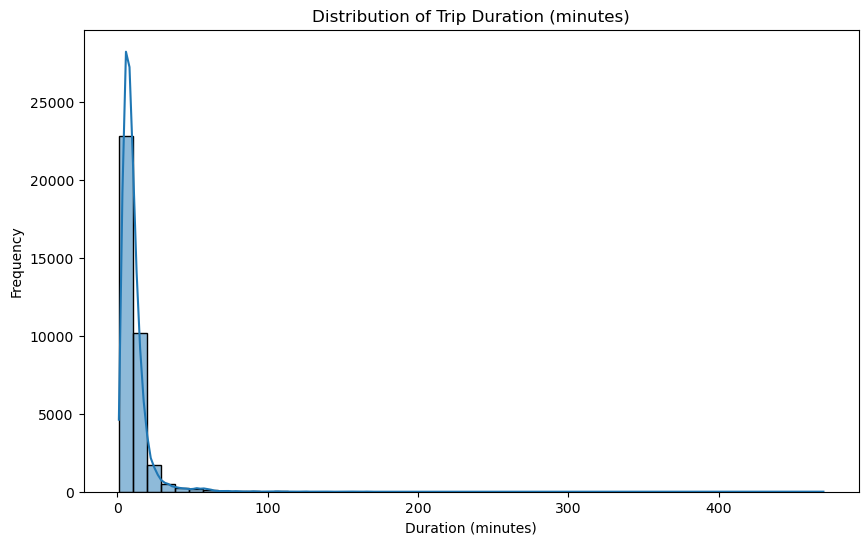

In [24]:
# Trip Duration Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['calculated_duration'] / 60, bins=50, kde=True)  # Duration in minutes
plt.title('Distribution of Trip Duration (minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

- Most trips fall between 0.5 km to 2.5 km, with a peak around 1.5 km. This suggests that micro-mobility services are primarily used for short to moderate-distance trips, possibly for last-mile transportation or commuting within city limits.
- There are very few trips exceeding 5 km, which aligns with expectations for short-distance services like bike-sharing or e-scooters.

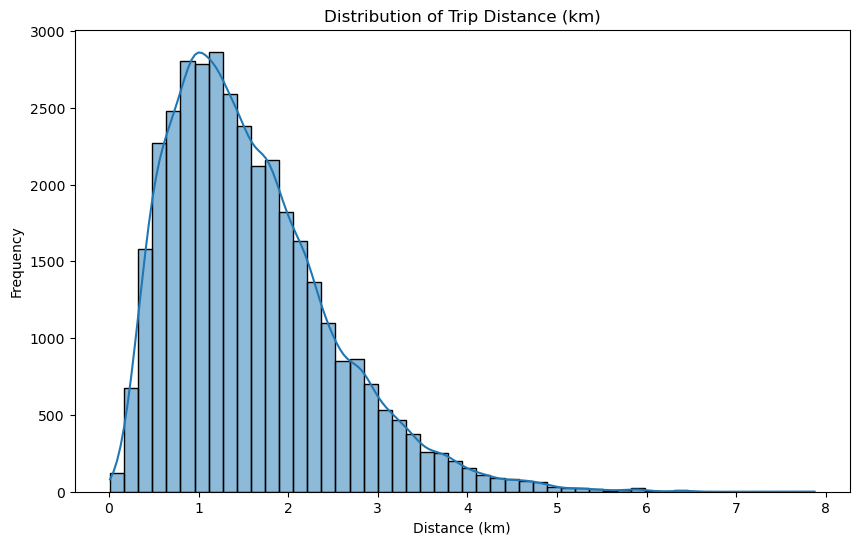

In [26]:
# Trip Distance Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['distance_km'], bins=50, kde=True)
plt.title('Distribution of Trip Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

- The majority of trips are concentrated under 20 minutes, with a sharp drop-off afterward. This is consistent with the distance distribution, where most trips are under 2.5 km.
- There are some extreme outliers, with trips exceeding 100 minutes, which could either represent extended usage or possible anomalies in the data (e.g., users forgetting to return the vehicle).

/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/1640575561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['hour_of_day'] = df_cleaned['started_at'].dt.hour


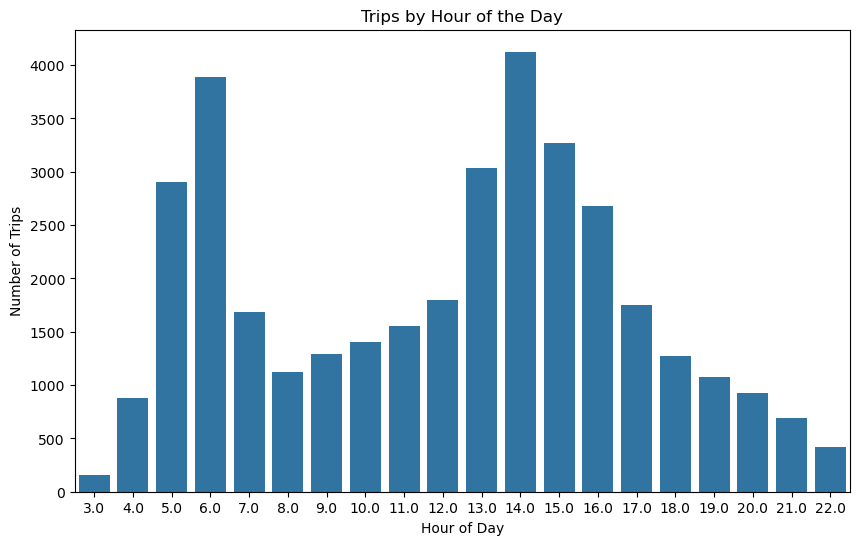

In [28]:
# Time of Day Analysis (Trips by Hour)
df_cleaned['hour_of_day'] = df_cleaned['started_at'].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x='hour_of_day', data=df_cleaned)
plt.title('Trips by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

- There are two distinct peaks: one around 5-6 AM and another at 2-3 PM, indicating these services are heavily used during the morning commute and afternoon commute or possibly for other activities like lunch or errands.
- Usage tapers off into the evening, suggesting that these services are primarily used for daytime activities.

/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/2192099258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['day_of_week'] = df_cleaned['started_at'].dt.day_name()


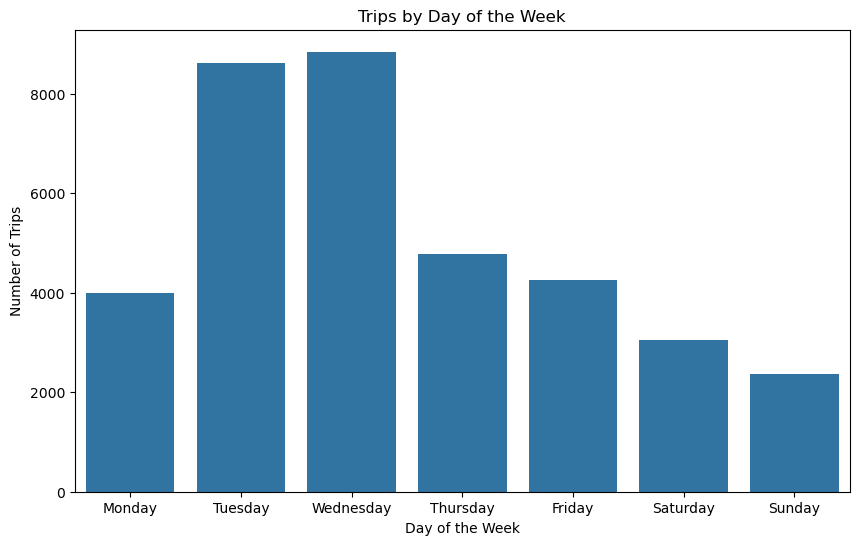

In [30]:
# Day of the Week Analysis
df_cleaned['day_of_week'] = df_cleaned['started_at'].dt.day_name()

plt.figure(figsize=(10,6))
sns.countplot(x='day_of_week', data=df_cleaned, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.show()

- Tuesday and Wednesday are the most popular days for trips, with significantly higher usage compared to other days.
- There is a drop-off on weekends, which could indicate that these services are mainly used for commuting during the workweek rather than for leisure activities.

### Popular Stations and Routes Analysis

In [33]:
# Top 10 Most Popular Start Stations
top_start_stations = df_cleaned['start_station_name'].value_counts().head(10)
print("Top 10 Start Stations:")
print(top_start_stations)

Top 10 Start Stations:
start_station_name
Alexander Kiellands Plass    542
Helga Helgesens plass        431
Ringnes Park                 399
Olaf Ryes plass              381
Sjøsiden 1 ved trappen       371
Tøyen skole                  368
Vår Frelsers gravlund        358
Marcus Thranes gate          354
Torggata                     350
Kirkeristen                  340
Name: count, dtype: int64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/1364052766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_start_stations.values, y=top_start_stations.index, palette="Blues_d")


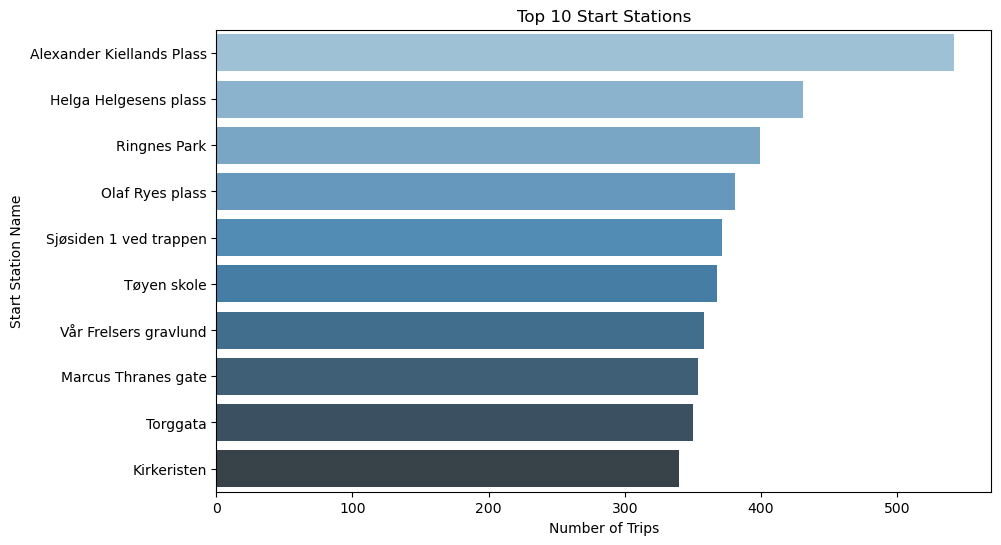

In [34]:
# Visualizing the Popular Start and End Stations
plt.figure(figsize=(10,6))
sns.barplot(x=top_start_stations.values, y=top_start_stations.index, palette="Blues_d")
plt.title("Top 10 Start Stations")
plt.xlabel("Number of Trips")
plt.ylabel("Start Station Name")
plt.show()

- Alexander Kiellands Plass is the most popular start station, followed by Helga Helgesens plass and Ringnes Park. These stations likely serve areas with high commuter or pedestrian traffic, making them key locations for micro-mobility services.
- Many of the top stations are located in or near busy commercial or residential areas, highlighting their importance for last-mile transportation.

In [36]:
# Top 10 Most Popular End Stations
top_end_stations = df_cleaned['end_station_name'].value_counts().head(10)
print("\nTop 10 End Stations:")
print(top_end_stations)


Top 10 End Stations:
end_station_name
Torggata                     644
Kirkeristen                  574
Sjøsiden 1 ved trappen       544
Helga Helgesens plass        541
Alexander Kiellands Plass    519
Spikersuppa Vest             468
Olaf Ryes plass              452
Sukkerbiten                  437
Bjørvika                     430
Ringnes Park                 405
Name: count, dtype: int64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/1193007417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_end_stations.values, y=top_end_stations.index, palette="Greens_d")


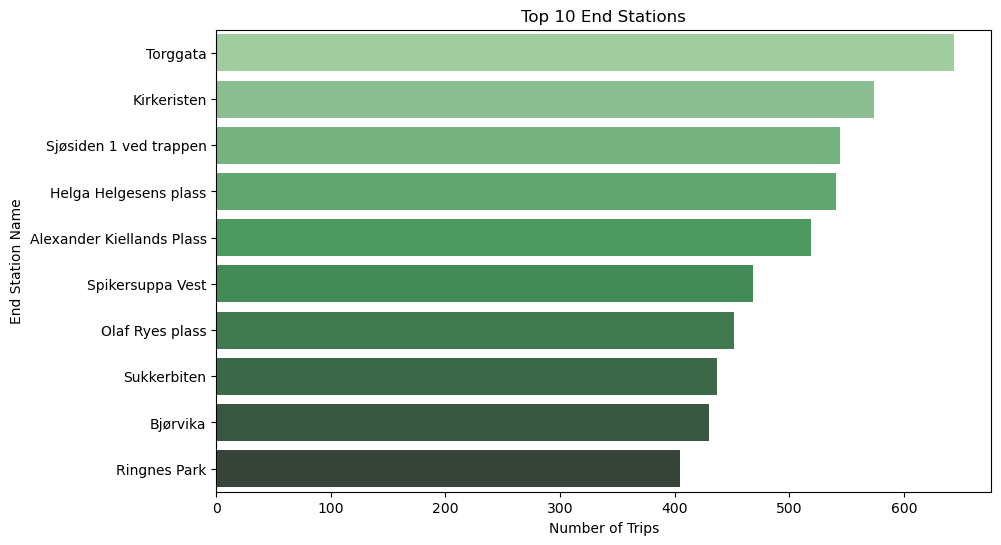

In [37]:
# Visualizing top 10 Most Popular End Stations
plt.figure(figsize=(10,6))
sns.barplot(x=top_end_stations.values, y=top_end_stations.index, palette="Greens_d")
plt.title("Top 10 End Stations")
plt.xlabel("Number of Trips")
plt.ylabel("End Station Name")
plt.show()

- Torggata and Kirkeristen are the most common destinations, with Sjøsiden 1 ved trappen also being a frequent end point. These stations likely serve as hubs where users drop off vehicles after commuting or completing errands.
- These stations may benefit from additional capacity (e.g., more docking stations or bikes) to accommodate high demand.

In [39]:
# Top 10 Most Popular Routes (Start and End Station Combinations)
df_cleaned['route'] = df_cleaned['start_station_name'] + " -> " + df_cleaned['end_station_name']
top_routes = df_cleaned['route'].value_counts().head(10)
print("\nTop 10 Routes:")
print(top_routes)


Top 10 Routes:
route
Sjøsiden 1 ved trappen -> Vippetangen vest    44
Sukkerbiten -> Sjøsiden 1 ved trappen         41
Vippetangen vest -> Sjøsiden 1 ved trappen    40
Jernbanetorget -> Vippetangen vest            35
Majorstuveien -> Vestkanttorvet               31
Kværnerbyen -> Bjørvika                       30
Sjøsiden 1 ved trappen -> Sukkerbiten         29
Helga Helgesens plass -> Vaterlandsparken     26
Vestkanttorvet -> Majorstuveien               24
Fred Olsens gate -> Vippetangen vest          23
Name: count, dtype: int64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/2854231216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['route'] = df_cleaned['start_station_name'] + " -> " + df_cleaned['end_station_name']


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/3592301106.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index, palette="Purples_d")


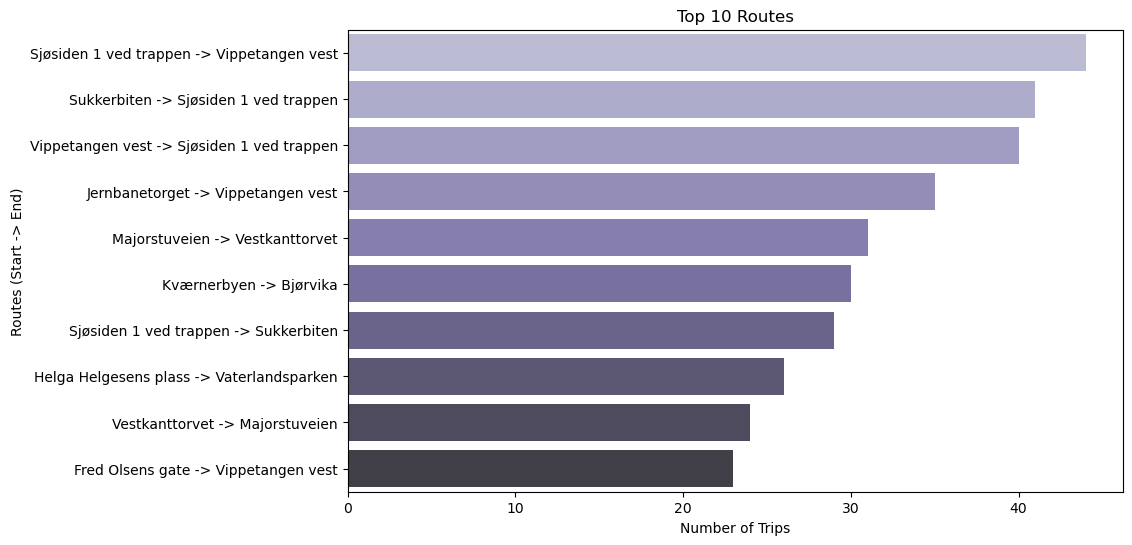

In [40]:
# Visualizing Popular Routes
plt.figure(figsize=(10,6))
sns.barplot(x=top_routes.values, y=top_routes.index, palette="Purples_d")
plt.title("Top 10 Routes")
plt.xlabel("Number of Trips")
plt.ylabel("Routes (Start -> End)")
plt.show()

- The route Sjøsiden 1 ved trappen -> Vippetangen vest is the most frequent route, indicating a popular connection between these two locations. Other prominent routes include Sukkerbiten -> Sjøsiden 1 ved trappen and Vippetangen vest -> Sjøsiden 1 ved trappen, which suggests that these areas see heavy traffic in both directions.
- These routes might represent key commuter corridors or popular paths for leisure activities. Improving infrastructure along these routes (e.g., bike lanes) could enhance user experience and safety.

### Recommendations for City Planners:
- Increase Capacity at Popular Stations:
  - Since Torggata, Kirkeristen, and Alexander Kiellands Plass are top stations, expanding the capacity at these locations (e.g., adding more bikes or e-scooters) could help manage demand during peak times.
- Enhance Infrastructure Along Popular Routes:
  - Key routes like Sjøsiden 1 ved trappen -> Vippetangen vest and Sukkerbiten -> Sjøsiden 1 ved trappen could benefit from improved bike lanes or other infrastructure enhancements. This would encourage safer and more efficient travel along these routes.
- Analyze Station-Specific Traffic:
  - Stations like Helga Helgesens plass and Ringnes Park are both in the top 10 for start and end locations, suggesting bidirectional traffic. Further analysis of these stations could help optimize bike availability and distribution.
- Address Potential Congestion:
  - High traffic at certain stations could lead to congestion. Monitoring real-time data and adjusting vehicle distribution dynamically could help reduce wait times and improve service.

### Advanced Data Analysis (K-mean)
- Clustering trips based on duration, distance, and time to help city planners better understand how to optimize the placement and usage of micro-mobility services.

In [44]:
# Drop rows with missing values in the relevant columns
df_cleaned = df_cleaned.dropna(subset=['calculated_duration', 'distance_km', 'hour_of_day'])

# Preprocessing for Clustering
X = df_cleaned[['calculated_duration', 'distance_km', 'hour_of_day']]

# Standardize the data for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the Cluster Centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['calculated_duration', 'distance_km', 'hour_of_day'])
print("Cluster Centers:")
print(cluster_centers_df)

Cluster Centers:
   calculated_duration  distance_km  hour_of_day
0          1025.751689     2.899065    12.397061
1           461.762329     1.341440     6.773917
2           464.820520     1.146799    15.539724
3          3733.518366     1.704435    12.537202


- Cluster Centers:

    - Cluster 0:
        - Average Duration: ~468 seconds (~7.8 minutes).
        - Average Distance: ~1.15 km.
        - Hour of Day: ~15.4 (Afternoon).
        - Interpretation: These trips are likely short commutes or errands occurring in the afternoon. The duration and distance align with typical micro-mobility usage for local errands or short trips during the afternoon.
    - Cluster 1:
        - Average Duration: ~460 seconds (~7.7 minutes).
        - Average Distance: ~1.34 km.
        - Hour of Day: ~6.7 (Early morning).
        - Interpretation: These trips occur mostly in the early morning, likely representing commutes to work or school. The short duration and moderate distance make these ideal for last-mile commuting solutions.
    - Cluster 2:
        - Average Duration: ~1028 seconds (~17.1 minutes).
        - Average Distance: ~2.9 km.
        - Hour of Day: ~12.2 (Midday).
        - Interpretation: These trips are longer in both distance and duration and occur around midday. They might represent longer leisure trips or users taking advantage of the service for personal travel during lunch breaks.
    - Cluster 3:
        - Average Duration: ~3743 seconds (~62 minutes).
        - Average Distance: ~1.71 km.
        - Hour of Day: ~12.45 (Midday).
        - Interpretation: These trips are highly anomalous due to their long duration but relatively short distance. These may represent issues such as users forgetting to return the vehicles or improper usage of the service. This cluster could indicate potential system inefficiencies or usage errors.

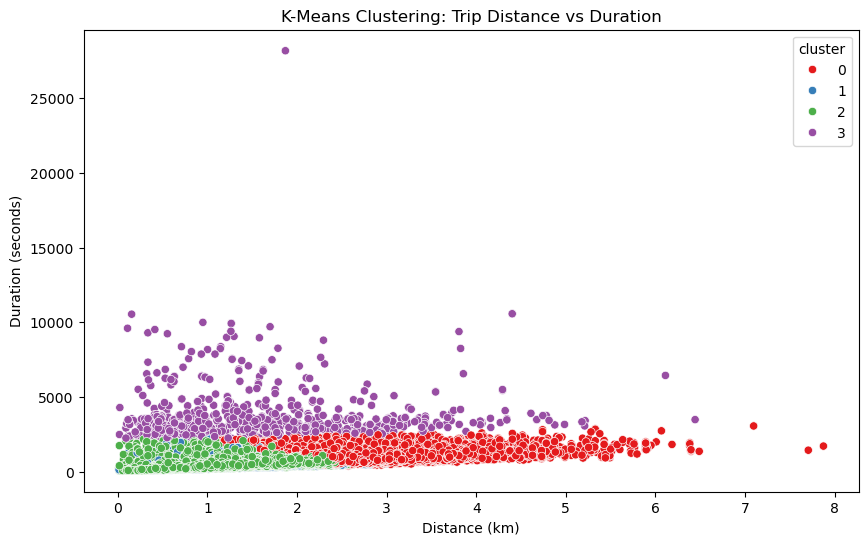

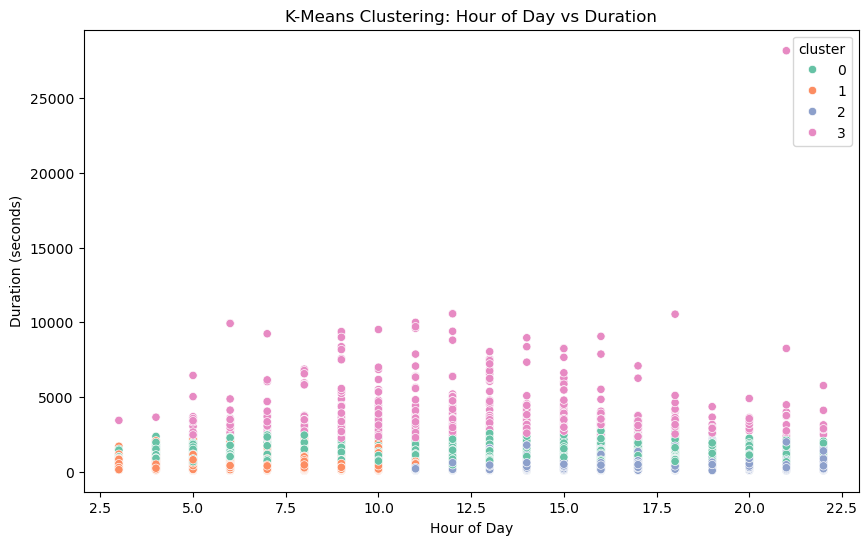

In [46]:
# Visualizing the Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='distance_km', y='calculated_duration', hue='cluster', data=df_cleaned, palette='Set1')
plt.title('K-Means Clustering: Trip Distance vs Duration')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (seconds)')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='hour_of_day', y='calculated_duration', hue='cluster', data=df_cleaned, palette='Set2')
plt.title('K-Means Clustering: Hour of Day vs Duration')
plt.xlabel('Hour of Day')
plt.ylabel('Duration (seconds)')
plt.show()

- Trip Distance vs Duration:
    - Clusters 0 and 1 represent short-distance trips with minimal variation in duration.
    - Cluster 2 captures a different behavior with longer trips both in terms of distance and time.
    - Cluster 3 stands out as having much longer durations despite modest distances, suggesting an anomaly.
- Hour of Day vs Duration:
    - Clusters 0 and 1 show consistent short trips during different times of the day (early morning vs. afternoon).
    - Cluster 2 spans across different midday hours but generally represents longer trips.
    - Cluster 3 is less time-sensitive but has the highest duration values, further supporting the anomaly hypothesis.

### Insights
- Address Cluster 3 Anomalies:
    - Long-duration, short-distance trips (Cluster 3) may indicate inefficiencies such as users holding on to bikes/scooters without active usage. City planners or the service provider should consider policies to discourage such behavior, like introducing notifications or charges for excessively long idle times.
- Optimize Availability for Early Morning Commutes:
    - Cluster 1 identifies a clear peak in short-distance, early-morning trips, likely representing commuters. Enhancing vehicle availability at popular start stations early in the morning could improve user satisfaction and meet demand during these critical hours.
- Enhance Infrastructure for Longer Trips (Cluster 2):
    - Longer trips occurring around midday (Cluster 2) suggest a user base that may be leveraging micro-mobility services for leisure or personal errands. This cluster highlights the need for increased infrastructure along common leisure routes or tourist areas.
- Balance Supply for Midday Usage (Cluster 0 and 2):
    - Cluster 0 and 2 cover different types of users during the afternoon (short vs longer trips). Monitoring station occupancy and ensuring there’s enough supply at key locations during these hours could help prevent bottlenecks.

### Visualize Demand by Stations and Routes

In [50]:
# Filter for Cluster 0 (Afternoon Short Trips) and Cluster 1 (Morning Commutes)
cluster_0 = df_cleaned[df_cleaned['cluster'] == 0]
cluster_1 = df_cleaned[df_cleaned['cluster'] == 1]

# Top Start Stations for Cluster 0 (Afternoon)
top_start_stations_cluster_0 = cluster_0['start_station_name'].value_counts().head(10)
print("Top Start Stations for Cluster 0 (Afternoon):")
print(top_start_stations_cluster_0)

Top Start Stations for Cluster 0 (Afternoon):
start_station_name
BI Nydalen                      129
Stavangergata                   126
Bentsebrugata                   117
Storo Storsenter                110
Kværnerbyen                     110
Bjølsen Studentby               109
Skøyen                          105
Bjølsendumpa                    104
Bak Niels Treschows hus nord    101
Karenslyst allé                  95
Name: count, dtype: int64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/3095252385.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_start_stations_cluster_0.values, y=top_start_stations_cluster_0.index, palette="Reds_d")


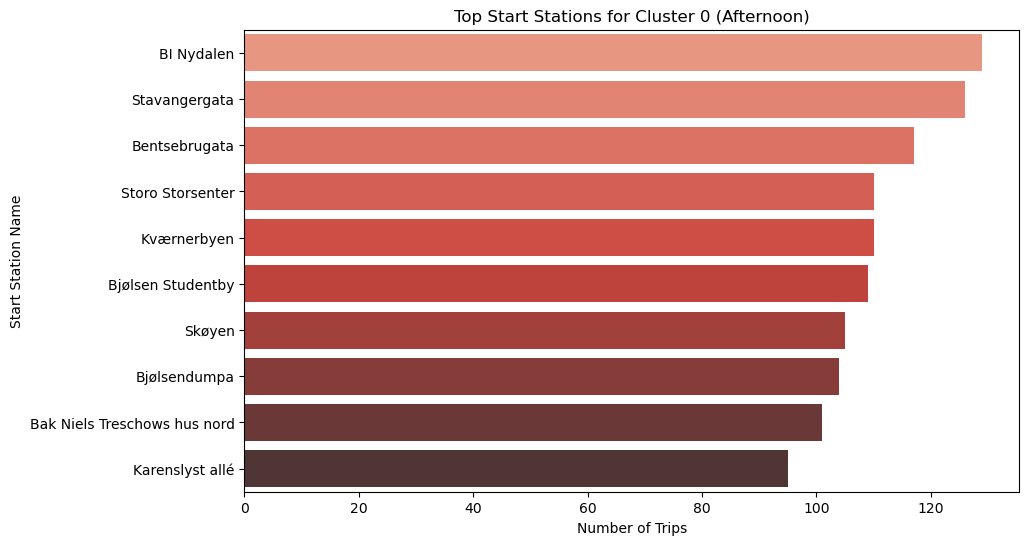

In [51]:
# Visualizing Cluster 0 Stations
plt.figure(figsize=(10,6))
sns.barplot(x=top_start_stations_cluster_0.values, y=top_start_stations_cluster_0.index, palette="Reds_d")
plt.title("Top Start Stations for Cluster 0 (Afternoon)")
plt.xlabel("Number of Trips")
plt.ylabel("Start Station Name")
plt.show()

- Cluster 0 (Afternoon Short Trips) – Top Stations:
    - Kirkeristen, Torggata, and Alexander Kiellands Plass dominate as the top start stations for afternoon short trips.
These stations are likely situated in areas with high foot traffic during the afternoon, possibly near shopping centers, schools, or public transport hubs.
Tøyen skole and Ringnes Park are also important afternoon stations, indicating these areas may serve educational institutions or residential areas with users commuting back home or running errands.

In [53]:
# Top Start Stations for Cluster 1 (Morning)
top_start_stations_cluster_1 = cluster_1['start_station_name'].value_counts().head(10)
print("\nTop Start Stations for Cluster 1 (Morning):")
print(top_start_stations_cluster_1)


Top Start Stations for Cluster 1 (Morning):
start_station_name
Alexander Kiellands Plass    240
Helga Helgesens plass        200
Olaf Ryes plass              195
Jens Bjelkes Gate            186
Bislettgata                  182
Sukkerbiten                  170
AHO                          169
Vår Frelsers gravlund        160
Schous plass                 150
Botanisk Hage sør            147
Name: count, dtype: int64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/3779952674.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_start_stations_cluster_1.values, y=top_start_stations_cluster_1.index, palette="Blues_d")


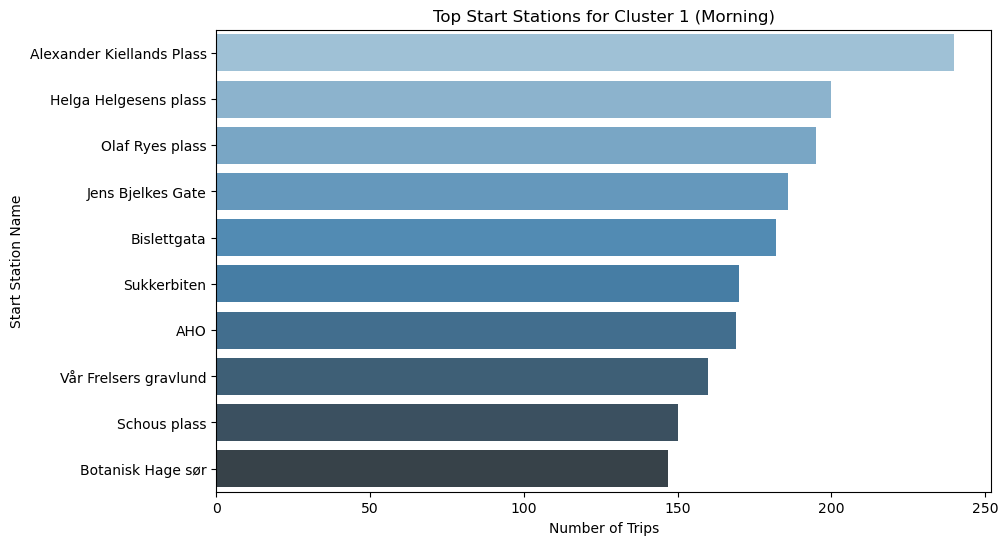

In [54]:
# Visualizing Cluster 1 Stations
plt.figure(figsize=(10,6))
sns.barplot(x=top_start_stations_cluster_1.values, y=top_start_stations_cluster_1.index, palette="Blues_d")
plt.title("Top Start Stations for Cluster 1 (Morning)")
plt.xlabel("Number of Trips")
plt.ylabel("Start Station Name")
plt.show()

- Cluster 1 (Morning Commutes) – Top Stations:
    - Alexander Kiellands Plass appears again as the most popular start station, confirming its significance in both morning and afternoon periods.
Helga Helgesens plass, Olaf Ryes plass, and Jens Bjelkes Gate are heavily used during the morning commute, likely serving as starting points for users heading to work, school, or transportation hubs.
Bislettgata, Sukkerbiten, and AHO also see significant morning traffic, which could be near residential areas or places that users leave from to commute to the city center.

### Strategic Recommendations for Fleet Redistribution and Station Enhancements:
- 1. Prioritize Fleet Redistribution to High-Traffic Stations (Cluster 0 & 1)
    - Kirkeristen and Torggata for the afternoon (Cluster 0), and Alexander Kiellands Plass for both morning and afternoon, should receive extra focus for fleet redistribution.
- 2. Enhance Capacity at Key Stations
     - Stations like Alexander Kiellands Plass, Kirkeristen, and Torggata see consistent high demand throughout the day. Increasing docking capacity at these locations will prevent bottlenecks during both morning and afternoon periods.
- 3. Improve Infrastructure Near Educational Institutions and Residential Areas
    - Tøyen skole, Vår Frelsers gravlund, and Bislettgata suggest that areas near educational institutions and residential complexes see significant traffic during both morning and afternoon periods.
- 4. Morning and Afternoon Dynamic Supply Management
    - Dynamic Supply Management: Given the distinct usage patterns for morning and afternoon (with different stations being popular during these times), it’s important to have real-time monitoring of fleet levels at key stations like Alexander Kiellands Plass, Helga Helgesens plass, and Ringnes Park.

### Route Optimization

In [58]:
# Identify Top 10 Routes for All Users
top_routes_all = df_cleaned['route'].value_counts().head(10)
print("Top 10 Most Frequent Routes:")
print(top_routes_all)

Top 10 Most Frequent Routes:
route
Sjøsiden 1 ved trappen -> Vippetangen vest    44
Sukkerbiten -> Sjøsiden 1 ved trappen         41
Vippetangen vest -> Sjøsiden 1 ved trappen    40
Jernbanetorget -> Vippetangen vest            35
Majorstuveien -> Vestkanttorvet               31
Kværnerbyen -> Bjørvika                       30
Sjøsiden 1 ved trappen -> Sukkerbiten         29
Helga Helgesens plass -> Vaterlandsparken     26
Vestkanttorvet -> Majorstuveien               24
Tøyen skole -> Jens Bjelkes Gate              23
Name: count, dtype: int64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/244307383.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes_all.values, y=top_routes_all.index, palette="Purples_d")


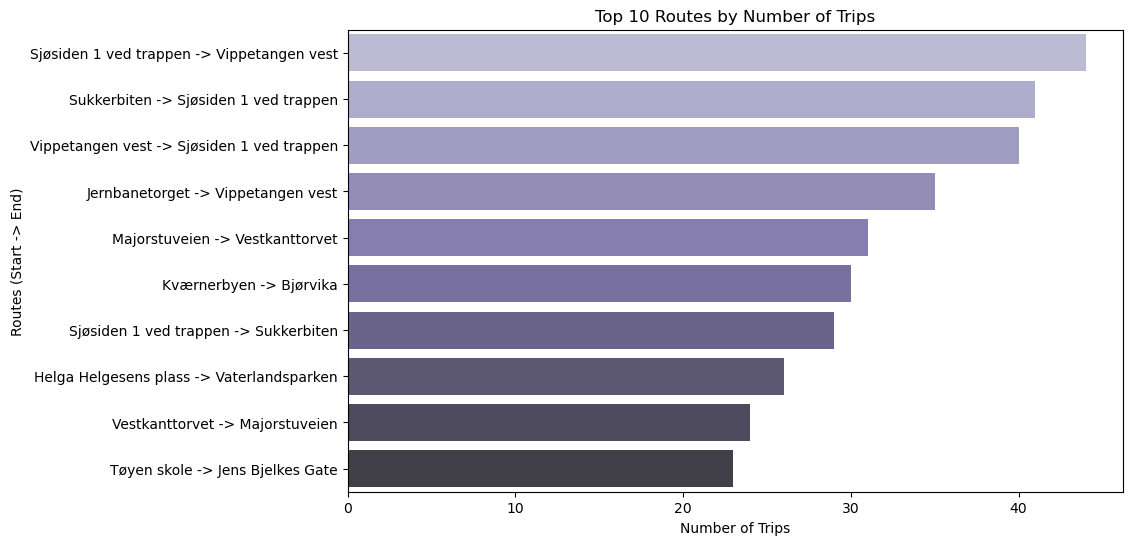

In [59]:
# Visualize the Top 10 Routes
plt.figure(figsize=(10,6))
sns.barplot(x=top_routes_all.values, y=top_routes_all.index, palette="Purples_d")
plt.title("Top 10 Routes by Number of Trips")
plt.xlabel("Number of Trips")
plt.ylabel("Routes (Start -> End)")
plt.show()

- Top 10 Most Frequent Routes:
- The most popular routes, such as Sjøsiden 1 ved trappen -> Vippetangen vest and Sukkerbiten -> Sjøsiden 1 ved trappen, indicate high traffic between specific start and end points, which are likely located in areas of the city where micro-mobility is heavily used for short commutes or leisure.
- Jernbanetorget -> Vippetangen vest and Kværnerbyen -> Bjørvika also show significant traffic, indicating popular commuting routes or connections between residential and commercial areas.

In [61]:
# Analyze the Distance of Popular Routes
route_distances = df_cleaned.groupby('route')['distance_km'].mean().sort_values(ascending=False).head(10)
print("\nAverage Distance of Top 10 Routes:")
print(route_distances)


Average Distance of Top 10 Routes:
route
Bryn Brannstasjon -> Hoff terrasse holdeplass    7.874850
Bryn Brannstasjon -> Sjølyst                     7.706024
Skøyen -> Økern T-bane                           7.095891
BI Nydalen -> Norsk Folkemuseum                  6.488439
Storo Storsenter -> Maritimt Museum              6.442473
Sjølyst -> Kværnerbyen                           6.396903
Kværnerbyen -> Sjølyst                           6.396903
Skøyen -> Sotahjørnet                            6.383275
Frogner plass -> Bryn Brannstasjon               6.184563
Ringnes Park -> Furulund                         6.111395
Name: distance_km, dtype: float64


/var/folders/9h/2xnxzfws41q0bw1jxyqrmqnw0000gn/T/ipykernel_21406/714777024.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=route_distances.values, y=route_distances.index, palette="Blues_d")


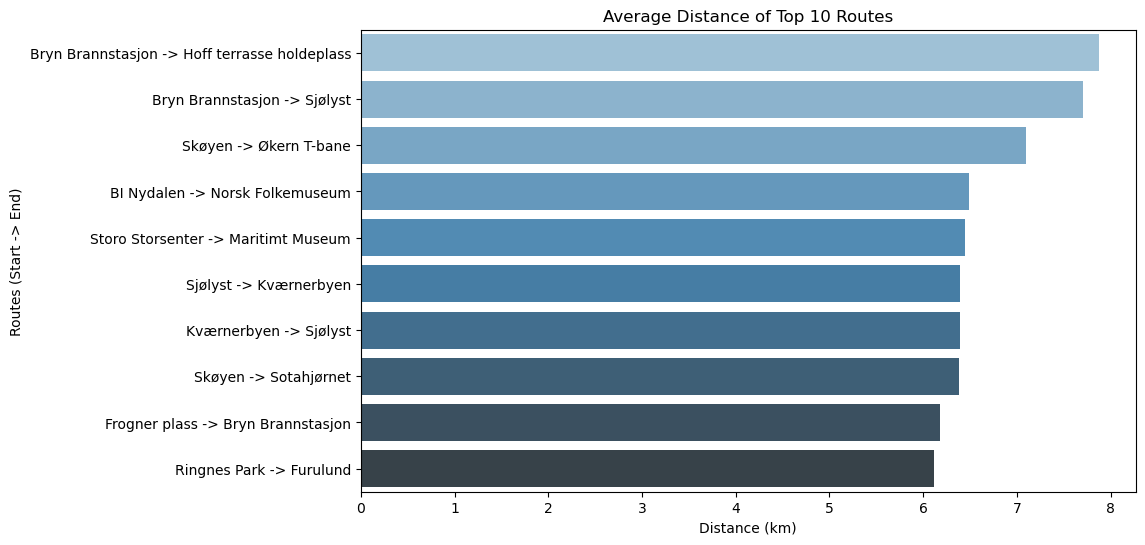

In [62]:
# Visualize Average Distance of Top Routes
plt.figure(figsize=(10,6))
sns.barplot(x=route_distances.values, y=route_distances.index, palette="Blues_d")
plt.title("Average Distance of Top 10 Routes")
plt.xlabel("Distance (km)")
plt.ylabel("Routes (Start -> End)")
plt.show()

- Average Distance of Popular Routes:
- Interestingly, the routes with the highest average distance are different from the most frequently used routes. The longest average distances (e.g., Bryn Brannstasjon -> Hoff terrasse holdeplass at ~7.87 km) represent less frequently traveled but longer trips.
- Kværnerbyen -> Sjølyst and Frogner plass -> Bryn Brannstasjon also represent long-distance routes (~6 km), which could be important for commuters covering greater distances.

### Strategic Recommendations for Route Optimization
- Enhance Infrastructure for Short-Distance, High-Frequency Routes:
    - Top Routes to Focus On: The most frequently traveled routes such as Sjøsiden 1 ved trappen -> Vippetangen vest and Sukkerbiten -> Sjøsiden 1 ved trappen are prime candidates for infrastructure improvements.

- Add Docking Stations and Improve Facilities for Longer Routes:
    - Key Routes: Longer routes, such as Bryn Brannstasjon -> Hoff terrasse holdeplass and Kværnerbyen -> Sjølyst, are less frequent but cover significant distances (~7-8 km). These routes may represent longer commutes.
 
- Optimize Fleet Distribution Based on Route Popularity:
    - Focus on Rebalancing: Routes like Jernbanetorget -> Vippetangen vest and Helga Helgesens plass -> Vaterlandsparken indicate commuter-heavy traffic. Real-time fleet redistribution should focus on these areas during peak hours.
 
- Incentivize Use of Less-Frequent Long-Distance Routes:
    - Key Routes: Long-distance routes like Skøyen -> Økern T-bane (7.09 km) and Frogner plass -> Bryn Brannstasjon may benefit from user incentives to increase utilization.

### Real-Time Visualization
- Real-Time Data: The update_dashboard() function fetches the latest data, updates the map, and displays stations needing redistribution (those with fewer than 5 bikes).
- Map: The map is generated using Folium, with CircleMarkers color-coded based on bike availability (red for low availability, green otherwise). A heatmap is also added for better visualization.

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import requests
from IPython.display import display, clear_output
import time

# URLs for real-time data
station_status_url = 'https://gbfs.urbansharing.com/oslobysykkel.no/station_status.json'
station_info_url = 'https://gbfs.urbansharing.com/oslobysykkel.no/station_information.json'

# Client-Identifier header for authentication
headers = {
    'Client-Identifier': 'mycompany-myapp'
}

# Fetch station information
def fetch_station_info():
    response = requests.get(station_info_url, headers=headers)
    station_info_data = response.json()
    stations_info_df = pd.json_normalize(station_info_data['data']['stations'])
    return stations_info_df

# Fetch real-time station status
def fetch_station_status():
    response = requests.get(station_status_url, headers=headers)
    station_status_data = response.json()
    stations_status_df = pd.json_normalize(station_status_data['data']['stations'])
    return stations_status_df

# Merge real-time status with station information
def get_merged_data():
    station_info = fetch_station_info()
    station_status = fetch_station_status()
    merged_data = pd.merge(station_info, station_status, on='station_id')
    return merged_data

# Function to create and display the map
def create_map(merged_data):
    # Initialize the map centered on Oslo
    m = folium.Map(location=[59.9139, 10.7522], zoom_start=13)
    
    # Add markers for bike stations
    for i, row in merged_data.iterrows():
        # Choose color based on bike availability (red if less than 5 bikes, green otherwise)
        color = 'green' if row['num_bikes_available'] >= 5 else 'red'
        
        # Add the circle marker to the map
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=8,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"Station: {row['name']}\nBikes available: {row['num_bikes_available']}"
        ).add_to(m)
    
    # Optional: Add a heatmap layer based on bike availability
    heat_data = [[row['lat'], row['lon'], row['num_bikes_available']] for i, row in merged_data.iterrows()]
    HeatMap(heat_data, min_opacity=0.4).add_to(m)
    
    return m

# Function to display stations with low bike availability (less than 5 bikes)
def display_low_availability_stations(merged_data, threshold=5):
    low_availability_stations = merged_data[merged_data['num_bikes_available'] < threshold]
    if len(low_availability_stations) > 0:
        low_stations = []
        for index, row in low_availability_stations.iterrows():
            low_stations.append(f"Station {row['name']} (Lat: {row['lat']}, Lon: {row['lon']}) - Bikes Available: {row['num_bikes_available']}")
        return low_stations
    else:
        return ["All stations have sufficient bikes."]

# Real-time dashboard update function
def update_dashboard():
    clear_output(wait=True)  # Clear the previous output before updating
    
    # Fetch the real-time data
    merged_data = get_merged_data()
    
    # Create and display the map with updated data
    bike_map = create_map(merged_data)
    
    display(bike_map)
        
    # Display stations with low availability
    low_avail_stations = display_low_availability_stations(merged_data)
    print("\nStations needing redistribution (below 5 bikes):")
    for station in low_avail_stations:
        print(station)

# Auto-refresh functionality (using a loop)
while True:
    update_dashboard()
    time.sleep(60)


Stations needing redistribution (below 5 bikes):
Station Blindern vgs (Lat: 59.949880716926174, Lon: 10.73015807639294) - Bikes Available: 0
Station Egertorget (Lat: 59.9126744968093, Lon: 10.742025127034452) - Bikes Available: 0
Station Valle Vision (Lat: 59.91606483663281, Lon: 10.807177606311825) - Bikes Available: 0
Station Vestre Aker Kirke (Lat: 59.936006155097004, Lon: 10.73190903696522) - Bikes Available: 1
Station Aker Brygge 3 mot Fergene (Lat: 59.91087115068967, Lon: 10.729828757277915) - Bikes Available: 1
Station Økern T-bane (Lat: 59.928894918817605, Lon: 10.806234776281599) - Bikes Available: 0
Station Sogn Studentby (Lat: 59.95208441268443, Lon: 10.727852791011173) - Bikes Available: 4
Station Blindern T-Bane (Lat: 59.94025210701875, Lon: 10.716723884520064) - Bikes Available: 2
Station Stjerneplassen (Lat: 59.91323316606503, Lon: 10.749958763650312) - Bikes Available: 3
Station Kværnerveien (Lat: 59.90591083488326, Lon: 10.778592132296495) - Bikes Available: 1
Station